# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 30,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_286_drop0.25e500b512_custom/lnets_10000_1430-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_10_d_3_sparsity_286_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_10000_1430-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_10_d_3_sparsity_286_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/1048576 [00:00<?, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1048576 [00:00<?, ?it/s]

List length: 286
Number of monomials in a polynomial with 10 variables and degree 3: 286
Sparsity: 286
['0000000000', '0000000001', '0000000002', '0000000003', '0000000010', '0000000011', '0000000012', '0000000020', '0000000021', '0000000030', '0000000100', '0000000101', '0000000102', '0000000110', '0000000111', '0000000120', '0000000200', '0000000201', '0000000210', '0000000300', '0000001000', '0000001001', '0000001002', '0000001010', '0000001011', '0000001020', '0000001100', '0000001101', '0000001110', '0000001200', '0000002000', '0000002001', '0000002010', '0000002100', '0000003000', '0000010000', '0000010001', '0000010002', '0000010010', '0000010011', '0000010020', '0000010100', '0000010101', '0000010110', '0000010200', '0000011000', '0000011001', '0000011010', '0000011100', '0000012000', '0000020000', '0000020001', '0000020010', '0000020100', '0000021000', '0000030000', '0000100000', '0000100001', '0000100002', '0000100010', '0000100011', '0000100020', '0000100100', '0000100101', 

## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed: 14.0min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  0000000000-target  0000000001-target  0000000002-target  \
6252  1373158606             -0.761              0.391             -0.851   
4684  1373158606              0.349              0.152             -0.118   
1731  1373158606              0.469              0.156             -0.367   
4742  1373158606              0.278              0.612             -0.433   
4521  1373158606              0.638              0.931              0.557   

      0000000003-target  0000000010-target  0000000011-target  \
6252              0.303             -0.466              0.842   
4684              0.003             -0.015              0.547   
1731             -0.659              0.787              0.908   
4742             -0.832             -0.201             -0.422   
4521              0.845             -0.400             -0.521   

      0000000012-target  0000000020-target  0000000021-target  \
6252              0.802              0.776              0.226   
4684              0.646              0.597              0.596   
1731              0.314              0.478              0.935   
4742              0.001             -0.082             -0.092   
4521              0.678              0.361             -0.435   

      0000000030-target  0000000100-target  0000000101-target  \
6252             -0.686             -0.180              0.465   
4684              0.571             -0.554              0.057   
1731              0.371             -0.191              0.633   
4742              0.004              0.946             -0.438   
4521             -0.641              0.925              0.151   

      0000000102-target  0000000110-target  0000000111-target  \
6252             -0.023              0.806             -0.776   
4684              0.066              0.490             -0.542   
1731             -0.326              0.395             -0.556   
4742             -0.083             -0.671              0.335   
4521             -0.252             -0.598             -0.617   

      0000000120-target  0000000200-target  0000000201-target  \
6252             -0.722              0.139              0.074   
4684             -0.818             -0.848             -0.886   
1731              0.187              0.606              0.879   
4742             -0.008             -0.384             -0.656   
4521              0.391              0.622             -0.926   

      0000000210-target  0000000300-target  0000001000-target  \
6252              0.974              0.353             -0.909   
4684             -0.514             -0.922              0.985   
1731              0.190             -0.648              0.927   
4742             -0.644              0.960              0.318   
4521              0.736             -0.147              0.059   

      0000001001-target  0000001002-target  0000001010-target  \
6252              0.676              0.788              0.812   
4684              0.913              0.794              0.246   
1731              0.115             -0.344             -0.054   
4742             -0.650             -0.591              0.515   
4521             -0.590             -0.968              0.556   

      0000001011-target  0000001020-target  0000001100-target  \
6252             -0.316             -0.930             -0.466   
4684              0.778              0.364              0.070   
1731              0.111              0.285             -0.408   
4742              0.669              0.423             -0.535   
4521              0.517              0.080             -0.049   

      0000001101-target  0000001110-target  0000001200-target  \
6252             -0.316             -0.224             -0.478   
4684              0.047              0.991             -0.502   
1731             -0.878             -0.527              0.971   
4742             -0.255             -0.822              0.614   
4521              0.531             -0.471              0.241   

      0000002000-target  00000

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  0000000000-target  0000000001-target  0000000002-target  \
count      10000.000          10000.000          10000.000          10000.000   
mean  1373158606.000              0.005              0.002              0.004   
std            0.000              0.579              0.577              0.574   
min   1373158606.000             -1.000             -1.000             -1.000   
25%   1373158606.000             -0.496             -0.501             -0.493   
50%   1373158606.000              0.012              0.004              0.002   
75%   1373158606.000              0.501              0.504              0.499   
max   1373158606.000              1.000              1.000              1.000   

       0000000003-target  0000000010-target  0000000011-target  \
count          10000.000          10000.000          10000.000   
mean               0.002              0.001             -0.007   
std                0.579              0.576              0.578   
min               -1.000             -1.000             -1.000   
25%               -0.497             -0.498             -0.502   
50%                0.001              0.000             -0.012   
75%                0.498              0.506              0.489   
max                1.000              1.000              1.000   

       0000000012-target  0000000020-target  0000000021-target  \
count          10000.000          10000.000          10000.000   
mean               0.005             -0.003              0.002   
std                0.582              0.573              0.573   
min               -1.000             -1.000             -1.000   
25%               -0.499             -0.501             -0.494   
50%                0.002             -0.009              0.004   
75%                0.513              0.483              0.496   
max                1.000              1.000              1.000   

       0000000030-target  0000000100-target  0000000101-target  \
count          10000.000          10000.000          10000.000   
mean              -0.003              0.002             -0.009   
std                0.577              0.580              0.577   
min               -1.000             -1.000             -1.000   
25%               -0.498             -0.501             -0.513   
50%               -0.011             -0.000             -0.015   
75%                0.496              0.508              0.492   
max                1.000              1.000              1.000   

       0000000102-target  0000000110-target  0000000111-target  \
count          10000.000          10000.000          10000.000   
mean               0.001              0.001              0.001   
std                0.576              0.580              0.578   
min               -1.000             -1.000             -1.000   
25%               -0.491             -0.504             -0.505   
50%                0.003             -0.001              0.004   
75%                0.496              0.502              0.502   
max                1.000              1.000              1.000   

       0000000120-target  0000000200-target  0000000201-target  \
count          10000.000          10000.000          10000.000   
mean               0.003             -0.006             -0.001   
std                0.576              0.575              0.575   
min               -1.000             -1.000             -1.000   
25%               -0.493             -0.502             -0.499   
50%               -0.004             -0.006             -0.001   
75%                0.502              0.489              0.495   
max                1.000              1.000              1.000   

       0000000210-target  0000000300-target  0000001000-target  \
count          10000.000          10000.000          10000.000   
mean              -0.005              0.005             -0.001   
std                0.580              0.576              0.582   
min               -1.000             -1.000    

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 18020)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 18020)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 18020)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  0000000000-target  0000000001-target  0000000002-target  \
3003  1373158606              0.553              0.314              0.335   
5985  1373158606             -0.561              0.528              0.711   
6925  1373158606             -0.023             -0.958             -0.983   
9619  1373158606              0.702              0.730              0.392   
6916  1373158606             -0.540              0.825             -0.645   

      0000000003-target  0000000010-target  0000000011-target  \
3003             -0.066             -0.184              0.983   
5985             -0.299              0.691              0.768   
6925              0.004              0.689             -0.361   
9619             -0.246             -0.845             -0.312   
6916              0.172             -0.786              0.468   

      0000000012-target  0000000020-target  0000000021-target  \
3003             -0.859              0.629             -0.827   
5985              0.145              0.184             -0.645   
6925              0.829             -0.283              0.846   
9619              0.026              0.311              0.941   
6916             -0.377             -0.879             -0.021   

      0000000030-target  0000000100-target  0000000101-target  \
3003             -0.230              0.008             -0.143   
5985              0.813             -0.405             -0.594   
6925             -0.528              0.775              0.471   
9619              0.684              0.922             -0.339   
6916              0.657              0.844              0.060   

      0000000102-target  0000000110-target  0000000111-target  \
3003             -0.017             -0.450              0.993   
5985             -0.347              0.741              0.208   
6925              0.433             -0.358             -0.676   
9619             -0.929              0.001              0.573   
6916             -0.840              0.884              0.799   

      0000000120-target  0000000200-target  0000000201-target  \
3003             -0.414             -0.363              0.844   
5985              0.404             -0.312             -0.999   
6925              0.282              0.286              0.725   
9619              0.030             -0.415              0.740   
6916              0.060             -0.044              0.984   

      0000000210-target  0000000300-target  0000001000-target  \
3003             -0.428             -0.781             -0.377   
5985              0.112              0.233             -0.117   
6925              0.682              0.260              0.298   
9619              0.242             -0.721             -0.451   
6916             -0.101              0.420              0.987   

      0000001001-target  0000001002-target  0000001010-target  \
3003              0.628              0.543             -0.667   
5985             -0.208              0.355             -0.770   
6925             -0.904              0.434              0.219   
9619              0.960             -0.236             -0.996   
6916              0.198             -0.605              0.781   

      0000001011-target  0000001020-target  0000001100-target  \
3003             -0.521              0.362              0.887   
5985             -0.814              0.935             -0.377   
6925              0.690             -0.121             -0.573   
9619             -0.313             -0.959             -0.066   
6916             -0.236              0.250             -0.257   

      0000001101-target  0000001110-target  0000001200-target  \
3003              0.816              0.043              0.477   
5985              0.068             -0.522             -0.689   
6925             -0.461              0.661              0.305   
9619              0.351             -0.659             -0.774   
6916             -0.214             -0.867             -0.657   

      0000002000-target  00000

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  0000000000-target  0000000001-target  0000000002-target  \
8323  1373158606             -0.686             -0.980             -0.682   
5392  1373158606             -0.066              0.319             -0.873   
4718  1373158606             -0.741             -0.406             -0.724   
990   1373158606             -0.882              0.500             -0.837   
6498  1373158606             -0.367              0.440              0.533   

      0000000003-target  0000000010-target  0000000011-target  \
8323             -0.487             -0.191              0.248   
5392              0.010             -0.383             -0.390   
4718             -0.988             -0.042              0.846   
990               0.353             -0.159              0.802   
6498              0.993              0.089              0.696   

      0000000012-target  0000000020-target  0000000021-target  \
8323              0.069             -0.136              0.950   
5392              0.644             -0.670             -0.042   
4718             -0.588             -0.440              0.956   
990               0.645              0.919              0.317   
6498             -0.324              0.433             -0.128   

      0000000030-target  0000000100-target  0000000101-target  \
8323              0.962              0.888              0.951   
5392             -0.415              0.245             -0.887   
4718              0.578             -0.078              0.854   
990              -0.923             -0.838              0.208   
6498             -0.946             -0.003             -0.460   

      0000000102-target  0000000110-target  0000000111-target  \
8323             -0.663              0.633              0.604   
5392             -0.180              0.626              0.111   
4718              0.874              0.594              0.323   
990               0.877              0.497              0.136   
6498             -0.631             -0.632             -0.708   

      0000000120-target  0000000200-target  0000000201-target  \
8323             -0.387             -0.619             -0.333   
5392              0.432             -0.260             -0.561   
4718              0.023             -0.162              0.522   
990              -0.925              0.594             -0.251   
6498             -0.811              0.767              0.707   

      0000000210-target  0000000300-target  0000001000-target  \
8323             -0.370              0.603             -0.660   
5392              0.620              0.439             -0.700   
4718             -0.886             -0.776             -0.813   
990               0.691             -0.383              0.854   
6498             -0.562              0.622              0.602   

      0000001001-target  0000001002-target  0000001010-target  \
8323              0.844             -0.547             -0.294   
5392              0.321              0.532             -0.741   
4718             -0.161              0.087              0.060   
990               0.476              0.243              0.563   
6498             -0.310             -0.125             -0.836   

      0000001011-target  0000001020-target  0000001100-target  \
8323             -0.645              0.256             -0.635   
5392              0.005              0.984             -0.671   
4718              0.786             -0.728             -0.158   
990               0.105             -0.256             -0.894   
6498              0.332             -0.570             -0.181   

      0000001101-target  0000001110-target  0000001200-target  \
8323              0.606              0.946             -0.747   
5392             -0.975              0.878              0.856   
4718             -0.077             -0.783              0.187   
990               0.174             -0.187             -0.433   
6498              0.611             -0.625             -0.248   

      0000002000-target  00000

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  0000000000-target  0000000001-target  0000000002-target  \
7217  1373158606             -0.686              0.247              0.047   
8291  1373158606              0.677             -0.423              0.547   
4607  1373158606              0.290              0.466              0.625   
5114  1373158606              0.990             -0.718             -0.679   
1859  1373158606             -0.548              0.273             -0.020   

      0000000003-target  0000000010-target  0000000011-target  \
7217             -0.316              0.113             -0.625   
8291             -0.488              0.644              0.918   
4607              0.106             -0.242             -0.305   
5114              0.231              0.981              0.457   
1859              0.757             -0.606              0.828   

      0000000012-target  0000000020-target  0000000021-target  \
7217              0.243             -0.191             -0.054   
8291             -0.283              0.354             -0.613   
4607              0.198             -0.043             -0.093   
5114              0.290             -0.827              0.775   
1859             -0.827             -0.229              0.958   

      0000000030-target  0000000100-target  0000000101-target  \
7217             -0.289             -0.746             -0.114   
8291             -0.465             -0.333             -0.533   
4607              0.178             -0.305             -0.454   
5114              0.846              0.261             -0.143   
1859             -0.274             -0.205              0.230   

      0000000102-target  0000000110-target  0000000111-target  \
7217             -0.177              0.697             -0.583   
8291             -0.609             -0.563              0.478   
4607             -0.254              0.076             -0.818   
5114             -0.856              0.565              0.598   
1859             -0.023              0.287              0.899   

      0000000120-target  0000000200-target  0000000201-target  \
7217              0.604             -0.559              0.801   
8291             -0.005              0.344              0.432   
4607             -0.534              0.627             -0.076   
5114              0.461              0.594             -0.203   
1859             -0.156              0.434              0.161   

      0000000210-target  0000000300-target  0000001000-target  \
7217             -0.674              0.974             -0.163   
8291              0.846             -0.984             -0.970   
4607              0.491             -0.703             -0.549   
5114              0.257              0.164              0.872   
1859              0.928             -0.150              0.962   

      0000001001-target  0000001002-target  0000001010-target  \
7217              0.478              0.001             -0.558   
8291             -0.133              0.766              0.673   
4607              0.569             -0.704             -0.182   
5114             -0.397             -0.212             -0.725   
1859             -0.513             -0.368              0.950   

      0000001011-target  0000001020-target  0000001100-target  \
7217             -0.987              0.504              0.030   
8291              0.315              0.134              0.553   
4607             -0.929              0.564             -0.910   
5114             -0.722             -0.920             -0.967   
1859             -0.041             -0.382             -0.038   

      0000001101-target  0000001110-target  0000001200-target  \
7217              0.802              0.806             -0.898   
8291              0.039             -0.788              0.092   
4607             -0.128              0.370              0.334   
5114             -0.995             -0.163             -0.697   
1859             -0.893              0.687             -0.132   

      0000002000-target  00000

## Interpretation Network Training

In [ ]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 14 Complete [00h 29m 52s]
val_loss: 0.7099549174308777

Best val_loss So Far: 0.7099549174308777
Total elapsed time: 06h 11m 27s

Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
dense_block_1/u...|True              |True              
dense_block_1/n...|1                 |2                 
dense_block_1/u...|32                |32                
dense_block_1/d...|0.25              |0.25              
dense_block_1/u...|128               |128               
regression_head...|0                 |0                 
optimizer         |adam              |adam              
learning_rate     |0.0001            |0.0001            
dense_block_1/u...|256               |256               

Epoch 1/500
254/254 [==============================] - 20s 79ms/step - loss: 1.3896 - val_loss: 1.4154
Epoch 2/500
254/254 [==============================] - 20s 78ms/step - loss: 1.2114 - val_loss: 1.0272
Epoch 3/500
254/254 [==============================] - 20s 7

## Evaluate Interpretation Net

In [53]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 64
Score: 0.41032883524894714
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 256
Score: 0.41202396154403687
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 1024
Score: 0.4131450653076172
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 1
de

In [54]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17161)]           0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 17161)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              17573888  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 17447)            

In [55]:
scores_list[-1]

MAE  RMSE   MAPE  Accuracy  \
inetPoly_VS_targetPoly_valid     0.461 0.540 34.109     0.056   
inetPoly_VS_targetPoly_test      0.460 0.539 44.932     0.057   
inetPoly_VS_predLambda_valid       NaN   NaN    NaN       NaN   
inetPoly_VS_predLambda_test        NaN   NaN    NaN       NaN   
inetPoly_VS_lstsqTarget_valid    0.564 0.815 30.180     0.070   
inetPoly_VS_lstsqTarget_test     0.564 0.817 47.740     0.069   
inetPoly_VS_lstsqLambda_valid    0.564 0.815 30.180     0.070   
inetPoly_VS_lstsqLambda_test     0.564 0.817 47.740     0.069   
lstsqLambda_VS_predLambda_valid    NaN   NaN    NaN       NaN   
lstsqLambda_VS_predLambda_test     NaN   NaN    NaN       NaN   
lstsqLambda_VS_lstsqTarget_valid 0.000 0.000  0.000     1.000   
lstsqLambda_VS_lstsqTarget_test  0.000 0.000  0.000     1.000   
lstsqLambda_VS_targetPoly_valid  0.654 0.873 44.951     0.051   
lstsqLambda_VS_targetPoly_test   0.654 0.874 26.838     0.052   
predLambda_VS_lstsqTarget_valid    NaN   NaN    NaN       NaN   
predLambda_VS_lstsqTarget_test     NaN   NaN    NaN       NaN   
predLambda_VS_targetPoly_valid     NaN   NaN    NaN       NaN   
predLambda_VS_targetPoly_test      NaN   NaN    NaN       NaN   
lstsqTarget_VS_targetPoly_valid  0.654 0.873 44.951     0.051   
lstsqTarget_VS_targetPoly_test   0.654 0.874 26.838     0.052   

                                  Accuracy Multilabel  MAE FV  RMSE FV  \
inetPoly_VS_targetPoly_valid                    0.000   0.517    0.657   
inetPoly_VS_targetPoly_test                     0.000   0.524    0.665   
inetPoly_VS_predLambda_valid                      NaN   0.494    0.611   
inetPoly_VS_predLambda_test                       NaN   0.500    0.619   
inetPoly_VS_lstsqTarget_valid                   0.000   0.505    0.633   
inetPoly_VS_lstsqTarget_test                    0.000   0.511    0.640   
inetPoly_VS_lstsqLambda_valid                   0.000   0.505    0.633   
inetPoly_VS_lstsqLambda_test                    0.000   0.511    0.640   
lstsqLambda_VS_predLambda_valid                   NaN   0.129    0.173   
lstsqLambda_VS_predLambda_test                    NaN   0.129    0.173   
lstsqLambda_VS_lstsqTarget_valid                1.000   0.000    0.000   
lstsqLambda_VS_lstsqTarget_test                 1.000   0.000    0.000   
lstsqLambda_VS_targetPoly_valid                 0.000   0.191    0.254   
lstsqLambda_VS_targetPoly_test                  0.000   0.192    0.255   
predLambda_VS_lstsqTarget_valid                   NaN   0.129    0.173   
predLambda_VS_lstsqTarget_test                    NaN   0.129    0.173   
predLambda_VS_targetPoly_valid                    NaN   0.180    0.245   
predLambda_VS_targetPoly_test                     NaN   0.180    0.246   
lstsqTarget_VS_targetPoly_valid                 0.000   0.191    0.254   
lstsqTarget_VS_targetPoly_test                  0.000   0.192    0.255   

                                  MAPE FV  R2 FV  RAAE FV  RMAE FV  \
inetPoly_VS_targetPoly_valid        2.270  0.820    0.320    1.309   
inetPoly_VS_targetPoly_test         2.353  0.814    0.325    1.341   
inetPoly_VS_predLambda_valid        2.137  0.846    0.305    1.062   
inetPoly_VS_predLambda_test         2.448  0.840    0.309    1.100   
inetPoly_VS_lstsqTarget_valid       2.169  0.834    0.312    1.210   
inetPoly_VS_lstsqTarget_test        2.429  0.829    0.316    1.236   
inetPoly_VS_lstsqLambda_valid       2.169  0.834    0.312    1.210   
inetPoly_VS_lstsqLambda_test        2.429  0.829    0.316    1.236   
lstsqLambda_VS_predLambda_valid     0.475  0.990    0.073    0.377   
lstsqLambda_VS_predLambda_test      0.577  0.990    0.072    0.375   
lstsqLambda_VS_lstsqTarget_valid    0.000  1.000    0.000    0.000   
lstsqLambda_VS_lstsqTarget_test     0.000  1.000    0.000    0.000   
lstsqLambda_VS_targetPoly_valid     0.680  0.978    0.108    0.510   
lstsqLambda_VS_targetPoly_test      0.728  0.978    0.109    0.510   
predLambda_VS_lstsqTarget_valid     5.551  0.990    0.073    0.3

In [56]:
distrib_dict_list[-1]['MAE']

L-0   L-1   L-2   L-3   L-4   L-5   L-6  \
inetPoly_VS_targetPoly_valid     0.398 0.488 0.484 0.502 0.546 0.641 0.454   
inetPoly_VS_targetPoly_test      0.415 0.370 0.410 0.668 0.481 0.623 0.439   
inetPoly_VS_predLambda_valid     0.363 0.488 0.448 0.474 0.524 0.625 0.394   
inetPoly_VS_predLambda_test      0.388 0.346 0.417 0.660 0.462 0.629 0.413   
inetPoly_VS_lstsqTarget_valid    0.366 0.519 0.488 0.500 0.559 0.651 0.400   
inetPoly_VS_lstsqTarget_test     0.404 0.349 0.422 0.670 0.479 0.631 0.412   
inetPoly_VS_lstsqLambda_valid    0.366 0.519 0.488 0.500 0.559 0.651 0.400   
inetPoly_VS_lstsqLambda_test     0.404 0.349 0.422 0.670 0.479 0.631 0.412   
lstsqLambda_VS_predLambda_valid  0.123 0.146 0.159 0.140 0.151 0.125 0.142   
lstsqLambda_VS_predLambda_test   0.129 0.108 0.113 0.132 0.118 0.092 0.113   
lstsqLambda_VS_lstsqTarget_valid 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqLambda_VS_lstsqTarget_test  0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqLambda_VS_targetPoly_valid  0.154 0.211 0.192 0.176 0.198 0.200 0.229   
lstsqLambda_VS_targetPoly_test   0.203 0.163 0.151 0.180 0.178 0.155 0.179   
predLambda_VS_lstsqTarget_valid  0.123 0.146 0.159 0.140 0.151 0.125 0.142   
predLambda_VS_lstsqTarget_test   0.129 0.108 0.113 0.132 0.118 0.092 0.113   
predLambda_VS_targetPoly_valid   0.149 0.180 0.163 0.167 0.183 0.184 0.211   
predLambda_VS_targetPoly_test    0.176 0.166 0.144 0.163 0.166 0.164 0.163   
lstsqTarget_VS_targetPoly_valid  0.154 0.211 0.192 0.176 0.198 0.200 0.229   
lstsqTarget_VS_targetPoly_test   0.203 0.163 0.151 0.180 0.178 0.155 0.179   

                                   L-7   L-8   L-9  L-10  L-11  L-12  L-13  \
inetPoly_VS_targetPoly_valid     0.649 0.545 0.448 0.532 0.549 0.504 0.396   
inetPoly_VS_targetPoly_test      0.399 0.689 0.410 0.650 0.570 0.904 0.433   
inetPoly_VS_predLambda_valid     0.647 0.536 0.427 0.511 0.495 0.518 0.387   
inetPoly_VS_predLambda_test      0.400 0.709 0.380 0.669 0.562 0.918 0.412   
inetPoly_VS_lstsqTarget_valid    0.677 0.547 0.436 0.510 0.507 0.527 0.392   
inetPoly_VS_lstsqTarget_test     0.393 0.701 0.395 0.677 0.565 0.953 0.420   
inetPoly_VS_lstsqLambda_valid    0.677 0.547 0.436 0.510 0.507 0.527 0.392   
inetPoly_VS_lstsqLambda_test     0.393 0.701 0.395 0.677 0.565 0.953 0.420   
lstsqLambda_VS_predLambda_valid  0.140 0.117 0.110 0.145 0.145 0.122 0.115   
lstsqLambda_VS_predLambda_test   0.131 0.126 0.130 0.169 0.121 0.129 0.128   
lstsqLambda_VS_lstsqTarget_valid 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqLambda_VS_lstsqTarget_test  0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqLambda_VS_targetPoly_valid  0.223 0.199 0.178 0.168 0.210 0.184 0.182   
lstsqLambda_VS_targetPoly_test   0.205 0.187 0.187 0.237 0.184 0.224 0.204   
predLambda_VS_lstsqTarget_valid  0.140 0.117 0.110 0.145 0.145 0.122 0.115   
predLambda_VS_lstsqTarget_test   0.131 0.126 0.130 0.169 0.121 0.129 0.128   
predLambda_VS_targetPoly_valid   0.215 0.178 0.172 0.191 0.183 0.190 0.162   
predLambda_VS_targetPoly_test    0.181 0.189 0.173 0.207 0.181 0.212 0.178   
lstsqTarget_VS_targetPoly_valid  0.223 0.199 0.178 0.168 0.210 0.184 0.182   
lstsqTarget_VS_targetPoly_test   0.205 0.187 0.187 0.237 0.184 0.224 0.204   

                                  L-14  L-15  L-16  L-17  L-18  L-19  L-20  \
inetPoly_VS_targetPoly_valid     0.634 0.479 0.451 0.412 0.474 0.457 0.514   
inetPoly_VS_targetPoly_test      0.636 0.453 0.423 0.496 0.654 0.602 0.540   
inetPoly_VS_predLambda_valid     0.591 0.451 0.375 0.396 0.435 0.412 0.513   
inetPoly_VS_predLambda_test      0.628 0.390 0.374 0.466 0.657 0.556 0.514   
inetPoly_VS_lstsqTarget_valid    0.612 0.466 0.391 0.403 0.455 0.418 0.514   
inetPoly_VS_lstsqTarget_test     0.654 0.411 0.370 0.496 0.683 0.571 0.552   
inetPoly_VS_lstsqLambda_valid    0.612 0.466 0.391 0.403 0.455 0.418 0.514   
inetPoly_VS_lstsqLambda_test     0.654 0.411 0.370 0.496 0.683 0.571 0.552   
lstsqLambda_VS_predLambda_valid  0.153 0.128 0.101 0.12

In [57]:
distrib_dict_list[-1]['R2']

L-0   L-1   L-2   L-3   L-4   L-5   L-6  \
inetPoly_VS_targetPoly_valid     0.835 0.827 0.932 0.806 0.804 0.568 0.925   
inetPoly_VS_targetPoly_test      0.844 0.956 0.936 0.553 0.714 0.328 0.818   
inetPoly_VS_predLambda_valid     0.862 0.846 0.941 0.836 0.837 0.605 0.948   
inetPoly_VS_predLambda_test      0.874 0.964 0.937 0.561 0.745 0.367 0.849   
inetPoly_VS_lstsqTarget_valid    0.852 0.826 0.927 0.813 0.801 0.577 0.946   
inetPoly_VS_lstsqTarget_test     0.856 0.964 0.934 0.539 0.714 0.359 0.842   
inetPoly_VS_lstsqLambda_valid    0.852 0.826 0.927 0.813 0.801 0.577 0.946   
inetPoly_VS_lstsqLambda_test     0.856 0.964 0.934 0.539 0.714 0.359 0.842   
lstsqLambda_VS_predLambda_valid  0.988 0.984 0.989 0.987 0.986 0.985 0.994   
lstsqLambda_VS_predLambda_test   0.987 0.996 0.996 0.989 0.990 0.992 0.990   
lstsqLambda_VS_lstsqTarget_valid 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqLambda_VS_lstsqTarget_test  1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqLambda_VS_targetPoly_valid  0.982 0.969 0.986 0.981 0.977 0.964 0.983   
lstsqLambda_VS_targetPoly_test   0.966 0.991 0.993 0.979 0.976 0.980 0.974   
predLambda_VS_lstsqTarget_valid  0.988 0.983 0.990 0.986 0.986 0.985 0.994   
predLambda_VS_lstsqTarget_test   0.986 0.996 0.996 0.989 0.990 0.992 0.990   
predLambda_VS_targetPoly_valid   0.983 0.977 0.991 0.981 0.978 0.967 0.984   
predLambda_VS_targetPoly_test    0.972 0.990 0.993 0.982 0.979 0.976 0.980   
lstsqTarget_VS_targetPoly_valid  0.982 0.969 0.986 0.981 0.977 0.964 0.983   
lstsqTarget_VS_targetPoly_test   0.966 0.991 0.993 0.979 0.976 0.980 0.974   

                                   L-7   L-8   L-9  L-10  L-11  L-12  L-13  \
inetPoly_VS_targetPoly_valid     0.737 0.814 0.836 0.882 0.822 0.841 0.924   
inetPoly_VS_targetPoly_test      0.953 0.879 0.900 0.695 0.900 0.407 0.931   
inetPoly_VS_predLambda_valid     0.750 0.828 0.863 0.896 0.857 0.842 0.935   
inetPoly_VS_predLambda_test      0.954 0.877 0.916 0.698 0.908 0.417 0.933   
inetPoly_VS_lstsqTarget_valid    0.726 0.821 0.858 0.893 0.846 0.826 0.934   
inetPoly_VS_lstsqTarget_test     0.954 0.877 0.909 0.676 0.905 0.366 0.927   
inetPoly_VS_lstsqLambda_valid    0.726 0.821 0.858 0.893 0.846 0.826 0.934   
inetPoly_VS_lstsqLambda_test     0.954 0.877 0.909 0.676 0.905 0.366 0.927   
lstsqLambda_VS_predLambda_valid  0.990 0.993 0.993 0.992 0.989 0.992 0.994   
lstsqLambda_VS_predLambda_test   0.995 0.995 0.991 0.981 0.994 0.988 0.992   
lstsqLambda_VS_lstsqTarget_valid 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqLambda_VS_lstsqTarget_test  1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqLambda_VS_targetPoly_valid  0.971 0.978 0.980 0.988 0.975 0.979 0.988   
lstsqLambda_VS_targetPoly_test   0.987 0.989 0.980 0.966 0.987 0.961 0.978   
predLambda_VS_lstsqTarget_valid  0.989 0.993 0.993 0.992 0.989 0.992 0.994   
predLambda_VS_lstsqTarget_test   0.995 0.995 0.991 0.981 0.994 0.987 0.991   
predLambda_VS_targetPoly_valid   0.972 0.981 0.981 0.985 0.981 0.977 0.990   
predLambda_VS_targetPoly_test    0.990 0.989 0.982 0.973 0.986 0.963 0.980   
lstsqTarget_VS_targetPoly_valid  0.971 0.978 0.980 0.988 0.975 0.979 0.988   
lstsqTarget_VS_targetPoly_test   0.987 0.989 0.980 0.966 0.987 0.961 0.978   

                                  L-14  L-15  L-16  L-17  L-18  L-19  L-20  \
inetPoly_VS_targetPoly_valid     0.844 0.910 0.402 0.916 0.780 0.902 0.866   
inetPoly_VS_targetPoly_test      0.833 0.891 0.896 0.875 0.469 0.869 0.668   
inetPoly_VS_predLambda_valid     0.871 0.923 0.596 0.925 0.846 0.926 0.875   
inetPoly_VS_predLambda_test      0.845 0.923 0.927 0.899 0.542 0.887 0.711   
inetPoly_VS_lstsqTarget_valid    0.856 0.914 0.536 0.920 0.826 0.920 0.869   
inetPoly_VS_lstsqTarget_test     0.837 0.912 0.923 0.882 0.510 0.878 0.656   
inetPoly_VS_lstsqLambda_valid    0.856 0.914 0.536 0.920 0.826 0.920 0.869   
inetPoly_VS_lstsqLambda_test     0.837 0.912 0.923 0.882 0.510 0.878 0.656   
lstsqLambda_VS_predLambda_valid  0.993 0.993 0.981 0.99

In [58]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.6274489328040584


-0.0807820111513138*a**1.0*b**1.0*c**1.0 + 0.0475322119891644*a**1.0*b**1.0*d**1.0 - 0.179097250103951*a**1.0*b**1.0*e**1.0 + 0.121914938092232*a**1.0*b**1.0*f**1.0 + 0.0725702866911888*a**1.0*b**1.0*g**1.0 + 0.259911596775055*a**1.0*b**1.0*h**1.0 - 0.0364708378911018*a**1.0*b**1.0*i**1.0 + 0.180271416902542*a**1.0*b**1.0*j**1.0 - 0.00959222484380007*a**1.0*b**1.0 - 0.0385416150093079*a**1.0*b**2.0 - 0.120476171374321*a**1.0*c**1.0*d**1.0 - 0.123515389859676*a**1.0*c**1.0*e**1.0 - 0.177373543381691*a**1.0*c**1.0*f**1.0 + 0.160722672939301*a**1.0*c**1.0*g**1.0 + 0.0713832899928093*a**1.0*c**1.0*h**1.0 + 0.0254312269389629*a**1.0*c**1.0*i**1.0 - 0.021566167473793*a**1.0*c**1.0*j**1.0 - 0.120131380856037*a**1.0*c**1.0 - 0.0476898401975632*a**1.0*c**2.0 - 0.194436177611351*a**1.0*d**1.0*e**1.0 - 0.00639861635863781*a**1.0*d**1.0*f**1.0 - 0.00896947830915451*a**1.0*d**1.0*g**1.0 + 0.14243645966053*a**1.0*d**1.0*h**1.0 - 0.0414658710360527*a**1.0*d**1.0*i**1.0 - 0.108868226408958*a**1.0*d**1

In [59]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9178383244465297


-0.311101343878138*a**1.0*b**1.0*c**1.0 - 0.276680718000642*a**1.0*b**1.0*d**1.0 + 0.302489389388992*a**1.0*b**1.0*e**1.0 + 0.516091284035625*a**1.0*b**1.0*f**1.0 + 0.108016323817982*a**1.0*b**1.0*g**1.0 + 0.154824244315629*a**1.0*b**1.0*h**1.0 + 0.46964215388314*a**1.0*b**1.0*i**1.0 - 0.0604249108553509*a**1.0*b**1.0*j**1.0 + 1.1489096649917*a**1.0*b**1.0 - 0.483854000988956*a**1.0*b**2.0 + 0.0142264835978197*a**1.0*c**1.0*d**1.0 - 0.182717263386363*a**1.0*c**1.0*e**1.0 - 0.229300366298693*a**1.0*c**1.0*f**1.0 - 0.0156462934925458*a**1.0*c**1.0*g**1.0 + 0.28717925051746*a**1.0*c**1.0*h**1.0 + 0.593486964102422*a**1.0*c**1.0*i**1.0 - 0.18519342056104*a**1.0*c**1.0*j**1.0 + 0.73132974274679*a**1.0*c**1.0 + 0.162974692836653*a**1.0*c**2.0 + 0.139499334565042*a**1.0*d**1.0*e**1.0 - 0.134503277056175*a**1.0*d**1.0*f**1.0 + 0.380702340346906*a**1.0*d**1.0*g**1.0 - 0.322001490866673*a**1.0*d**1.0*h**1.0 + 0.527996159900802*a**1.0*d**1.0*i**1.0 - 0.196009229927814*a**1.0*d**1.0*j**1.0 + 0.011

In [60]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.0287094342906166*a**1.0*b**1.0*c**1.0 + 0.413322443525405*a**1.0*b**1.0*d**1.0 + 0.728865498373459*a**1.0*b**1.0*e**1.0 + 0.71214903405072*a**1.0*b**1.0*f**1.0 - 0.646014867317892*a**1.0*b**1.0*g**1.0 + 0.902419944558174*a**1.0*b**1.0*h**1.0 + 0.702357977270468*a**1.0*b**1.0*i**1.0 - 0.950712557786962*a**1.0*b**1.0*j**1.0 - 0.756073924949514*a**1.0*b**1.0 + 0.744292948656819*a**1.0*b**2.0 - 0.142472681200345*a**1.0*c**1.0*d**1.0 - 0.457116464377681*a**1.0*c**1.0*e**1.0 + 0.347334799522504*a**1.0*c**1.0*f**1.0 + 0.511300951194088*a**1.0*c**1.0*g**1.0 + 0.972646470108641*a**1.0*c**1.0*h**1.0 + 0.03636505143464*a**1.0*c**1.0*i**1.0 + 0.873229884147582*a**1.0*c**1.0*j**1.0 - 0.494301959760404*a**1.0*c**1.0 - 0.61468447399621*a**1.0*c**2.0 - 0.739013368112327*a**1.0*d**1.0*e**1.0 - 0.537147308147188*a**1.0*d**1.0*f**1.0 + 0.344584664106351*a**1.0*d**1.0*g**1.0 - 0.264639909740982*a**1.0*d**1.0*h**1.0 - 0.955360261127788*a**1.0*d**1.0*i**1.0 + 0.215281091170796*a**1.0*d**1.0*j**1.0 - 0.059

In [61]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.922859411792369


-0.155921071767807*a**1.0*b**1.0*c**1.0 - 0.0508003272116184*a**1.0*b**1.0*d**1.0 - 0.168878585100174*a**1.0*b**1.0*e**1.0 - 0.0524376258254051*a**1.0*b**1.0*f**1.0 + 0.122190363705158*a**1.0*b**1.0*g**1.0 + 0.0677675008773804*a**1.0*b**1.0*h**1.0 - 0.0982395932078362*a**1.0*b**1.0*i**1.0 + 0.0232289358973503*a**1.0*b**1.0*j**1.0 - 0.375750333070755*a**1.0*b**1.0 - 0.0834389626979828*a**1.0*b**2.0 - 0.17371441423893*a**1.0*c**1.0*d**1.0 - 0.309412151575089*a**1.0*c**1.0*e**1.0 - 0.119719661772251*a**1.0*c**1.0*f**1.0 - 0.126892805099487*a**1.0*c**1.0*g**1.0 - 0.0595076084136963*a**1.0*c**1.0*h**1.0 - 0.0519813261926174*a**1.0*c**1.0*i**1.0 - 0.362010508775711*a**1.0*c**1.0*j**1.0 - 0.505378186702728*a**1.0*c**1.0 - 0.314758151769638*a**1.0*c**2.0 - 0.0326902344822884*a**1.0*d**1.0*e**1.0 - 0.132853016257286*a**1.0*d**1.0*f**1.0 - 0.0217270888388157*a**1.0*d**1.0*g**1.0 - 0.0210957750678062*a**1.0*d**1.0*h**1.0 - 0.192137241363525*a**1.0*d**1.0*i**1.0 - 0.252699017524719*a**1.0*d**1.0*j

In [62]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9924768048815289


-0.0060866766803256*a**1.0*b**1.0*c**1.0 + 0.315105223934606*a**1.0*b**1.0*d**1.0 + 0.0584439867434425*a**1.0*b**1.0*e**1.0 - 0.323960401418673*a**1.0*b**1.0*f**1.0 + 0.118026996853872*a**1.0*b**1.0*g**1.0 + 0.219217003622124*a**1.0*b**1.0*h**1.0 - 0.0954011586196426*a**1.0*b**1.0*i**1.0 + 0.540137879048606*a**1.0*b**1.0*j**1.0 - 1.16191879383463*a**1.0*b**1.0 - 0.131194178078874*a**1.0*b**2.0 + 0.411492340524698*a**1.0*c**1.0*d**1.0 + 0.657353085725084*a**1.0*c**1.0*e**1.0 - 0.584348365012559*a**1.0*c**1.0*f**1.0 - 0.384432666343934*a**1.0*c**1.0*g**1.0 - 0.226617061940327*a**1.0*c**1.0*h**1.0 - 0.109458700641372*a**1.0*c**1.0*i**1.0 - 0.74146889268357*a**1.0*c**1.0*j**1.0 - 2.24932400159341*a**1.0*c**1.0 + 0.204153984113384*a**1.0*c**2.0 - 0.147782536876671*a**1.0*d**1.0*e**1.0 - 0.110290281781749*a**1.0*d**1.0*f**1.0 - 0.145799387943792*a**1.0*d**1.0*g**1.0 + 0.567839532208091*a**1.0*d**1.0*h**1.0 - 0.0587002967162401*a**1.0*d**1.0*i**1.0 + 0.521977638388592*a**1.0*d**1.0*j**1.0 - 0

In [63]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.0784548746232538*a**1.0*b**1.0*c**1.0 - 0.521526233997155*a**1.0*b**1.0*d**1.0 - 0.865107931060936*a**1.0*b**1.0*e**1.0 - 0.30127834051505*a**1.0*b**1.0*f**1.0 - 0.153915286906068*a**1.0*b**1.0*g**1.0 - 0.512498094326844*a**1.0*b**1.0*h**1.0 - 0.849490535247497*a**1.0*b**1.0*i**1.0 + 0.686176562918571*a**1.0*b**1.0*j**1.0 + 0.81037599767479*a**1.0*b**1.0 - 0.673220744178368*a**1.0*b**2.0 - 0.930489222136109*a**1.0*c**1.0*d**1.0 - 0.845991661171142*a**1.0*c**1.0*e**1.0 + 0.0148369838832538*a**1.0*c**1.0*f**1.0 - 0.629072044236282*a**1.0*c**1.0*g**1.0 - 0.111071354996506*a**1.0*c**1.0*h**1.0 - 0.441253922961363*a**1.0*c**1.0*i**1.0 - 0.422208046544039*a**1.0*c**1.0*j**1.0 - 0.676886570747831*a**1.0*c**1.0 + 0.341769574730688*a**1.0*c**2.0 + 0.710860622068798*a**1.0*d**1.0*e**1.0 + 0.606700271318206*a**1.0*d**1.0*f**1.0 + 0.495261016720103*a**1.0*d**1.0*g**1.0 + 0.24297097418652*a**1.0*d**1.0*h**1.0 - 0.909339827356451*a**1.0*d**1.0*i**1.0 + 0.0575905333490509*a**1.0*d**1.0*j**1.0 + 0.6

In [64]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.8138447511256572 (1000 Samples)
Mean (only positive): 0.8154808243053457 (998 Samples)


In [65]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.978053795431469 (1000 Samples)
Mean (only positive): 0.978053795431469 (1000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

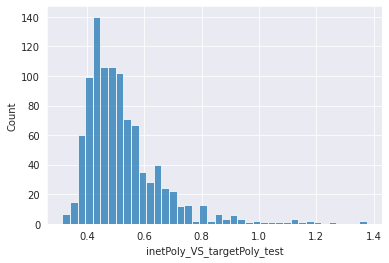

In [66]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

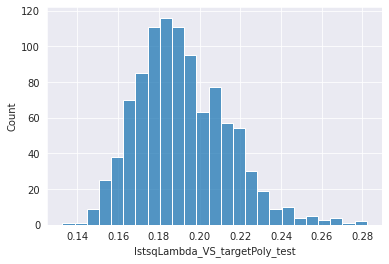

In [67]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

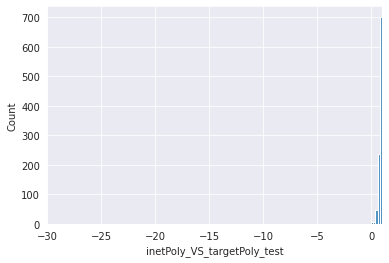

In [68]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

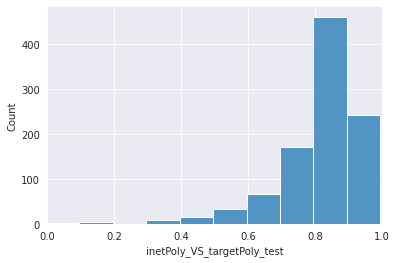

In [69]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

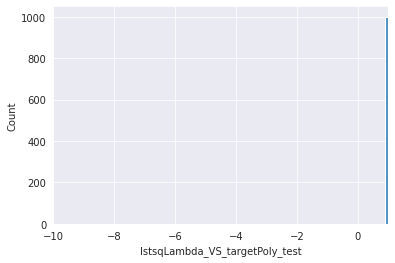

In [70]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

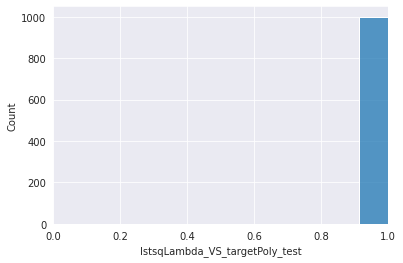

In [71]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [72]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [73]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [74]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [75]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [76]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [77]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


0.4302*a**1.0*b**1.0*c**1.0 - 0.9077*a**1.0*b**1.0*d**1.0 - 0.7188*a**1.0*b**1.0*e**1.0 + 0.8343*a**1.0*b**1.0*f**1.0 + 0.1901*a**1.0*b**1.0*g**1.0 - 0.8893*a**1.0*b**1.0*h**1.0 + 0.2329*a**1.0*b**1.0*i**1.0 + 0.4692*a**1.0*b**1.0*j**1.0 - 0.1093*a**1.0*b**1.0 + 0.5086*a**1.0*b**2.0 + 0.923*a**1.0*c**1.0*d**1.0 - 0.9254*a**1.0*c**1.0*e**1.0 - 0.6125*a**1.0*c**1.0*f**1.0 - 0.6639*a**1.0*c**1.0*g**1.0 - 0.808*a**1.0*c**1.0*h**1.0 + 0.1834*a**1.0*c**1.0*i**1.0 - 0.4814*a**1.0*c**1.0*j**1.0 + 0.3612*a**1.0*c**1.0 - 0.1967*a**1.0*c**2.0 + 0.686*a**1.0*d**1.0*e**1.0 - 0.3274*a**1.0*d**1.0*f**1.0 + 0.2967*a**1.0*d**1.0*g**1.0 - 0.9933*a**1.0*d**1.0*h**1.0 + 0.7092*a**1.0*d**1.0*i**1.0 - 0.1848*a**1.0*d**1.0*j**1.0 + 0.8062*a**1.0*d**1.0 - 1.0*a**1.0*d**2.0 - 0.8695*a**1.0*e**1.0*f**1.0 + 0.1646*a**1.0*e**1.0*g**1.0 + 0.4171*a**1.0*e**1.0*h**1.0 - 0.5675*a**1.0*e**1.0*i**1.0 + 0.3684*a**1.0*e**1.0*j**1.0 - 0.4116*a**1.0*e**1.0 - 0.3194*a**1.0*e**2.0 + 0.3752*a**1.0*f**1.0*g**1.0 - 0.0506*a**1.

LSTSQ Target Poly:


-0.1129*a**1.0*b**1.0*c**1.0 - 0.3375*a**1.0*b**1.0*d**1.0 - 0.6261*a**1.0*b**1.0*e**1.0 + 0.1709*a**1.0*b**1.0*f**1.0 + 0.5019*a**1.0*b**1.0*g**1.0 - 0.7481*a**1.0*b**1.0*h**1.0 + 0.0736*a**1.0*b**1.0*i**1.0 - 0.0531*a**1.0*b**1.0*j**1.0 + 1.1278*a**1.0*b**1.0 + 0.3089*a**1.0*b**2.0 + 1.1156*a**1.0*c**1.0*d**1.0 + 0.0245*a**1.0*c**1.0*e**1.0 - 0.3706*a**1.0*c**1.0*f**1.0 + 0.1118*a**1.0*c**1.0*g**1.0 - 0.5074*a**1.0*c**1.0*h**1.0 + 0.1461*a**1.0*c**1.0*i**1.0 - 0.2006*a**1.0*c**1.0*j**1.0 - 2.1546*a**1.0*c**1.0 + 0.4704*a**1.0*c**2.0 + 0.3517*a**1.0*d**1.0*e**1.0 - 0.9342*a**1.0*d**1.0*f**1.0 - 0.5554*a**1.0*d**1.0*g**1.0 - 0.3003*a**1.0*d**1.0*h**1.0 + 0.5205*a**1.0*d**1.0*i**1.0 + 0.2956*a**1.0*d**1.0*j**1.0 - 0.3969*a**1.0*d**1.0 - 0.0887*a**1.0*d**2.0 + 0.1202*a**1.0*e**1.0*f**1.0 + 0.3722*a**1.0*e**1.0*g**1.0 + 0.4824*a**1.0*e**1.0*h**1.0 - 0.2241*a**1.0*e**1.0*i**1.0 + 0.4867*a**1.0*e**1.0*j**1.0 - 3.757*a**1.0*e**1.0 + 0.6351*a**1.0*e**2.0 + 0.3557*a**1.0*f**1.0*g**1.0 - 0.027*

LSTSQ Lambda Poly:


-0.1129*a**1.0*b**1.0*c**1.0 - 0.3375*a**1.0*b**1.0*d**1.0 - 0.6261*a**1.0*b**1.0*e**1.0 + 0.1709*a**1.0*b**1.0*f**1.0 + 0.5019*a**1.0*b**1.0*g**1.0 - 0.7481*a**1.0*b**1.0*h**1.0 + 0.0736*a**1.0*b**1.0*i**1.0 - 0.0531*a**1.0*b**1.0*j**1.0 + 1.1278*a**1.0*b**1.0 + 0.3089*a**1.0*b**2.0 + 1.1156*a**1.0*c**1.0*d**1.0 + 0.0245*a**1.0*c**1.0*e**1.0 - 0.3706*a**1.0*c**1.0*f**1.0 + 0.1118*a**1.0*c**1.0*g**1.0 - 0.5074*a**1.0*c**1.0*h**1.0 + 0.1461*a**1.0*c**1.0*i**1.0 - 0.2006*a**1.0*c**1.0*j**1.0 - 2.1546*a**1.0*c**1.0 + 0.4704*a**1.0*c**2.0 + 0.3517*a**1.0*d**1.0*e**1.0 - 0.9342*a**1.0*d**1.0*f**1.0 - 0.5554*a**1.0*d**1.0*g**1.0 - 0.3003*a**1.0*d**1.0*h**1.0 + 0.5205*a**1.0*d**1.0*i**1.0 + 0.2956*a**1.0*d**1.0*j**1.0 - 0.3969*a**1.0*d**1.0 - 0.0887*a**1.0*d**2.0 + 0.1202*a**1.0*e**1.0*f**1.0 + 0.3722*a**1.0*e**1.0*g**1.0 + 0.4824*a**1.0*e**1.0*h**1.0 - 0.2241*a**1.0*e**1.0*i**1.0 + 0.4867*a**1.0*e**1.0*j**1.0 - 3.757*a**1.0*e**1.0 + 0.6351*a**1.0*e**2.0 + 0.3557*a**1.0*f**1.0*g**1.0 - 0.027*

I-Net Poly:


-0.00760000012814999*a**1.0*b**1.0*c**1.0 + 0.0667999982833862*a**1.0*b**1.0*d**1.0 - 0.000699999975040555*a**1.0*b**1.0*e**1.0 + 0.272899985313416*a**1.0*b**1.0*f**1.0 + 0.0599000006914139*a**1.0*b**1.0*g**1.0 - 0.158000007271767*a**1.0*b**1.0*h**1.0 + 0.00899999961256981*a**1.0*b**1.0*i**1.0 + 0.0736000016331673*a**1.0*b**1.0*j**1.0 + 0.0359000004827976*a**1.0*b**1.0 - 0.0226000007241964*a**1.0*b**2.0 - 0.0636000037193298*a**1.0*c**1.0*d**1.0 - 0.178200006484985*a**1.0*c**1.0*e**1.0 - 0.0252000000327826*a**1.0*c**1.0*f**1.0 - 0.00999999977648258*a**1.0*c**1.0*g**1.0 - 0.00419999985024333*a**1.0*c**1.0*h**1.0 - 0.0646999999880791*a**1.0*c**1.0*i**1.0 - 0.108300000429153*a**1.0*c**1.0*j**1.0 - 0.109499998390675*a**1.0*c**1.0 - 0.0982000008225441*a**1.0*c**2.0 - 0.189500004053116*a**1.0*d**1.0*e**1.0 - 0.0560000017285347*a**1.0*d**1.0*f**1.0 - 0.0742999985814095*a**1.0*d**1.0*g**1.0 + 0.023700000718236*a**1.0*d**1.0*h**1.0 + 0.0675999969244003*a**1.0*d**1.0*i**1.0 - 0.0832000002264977*a

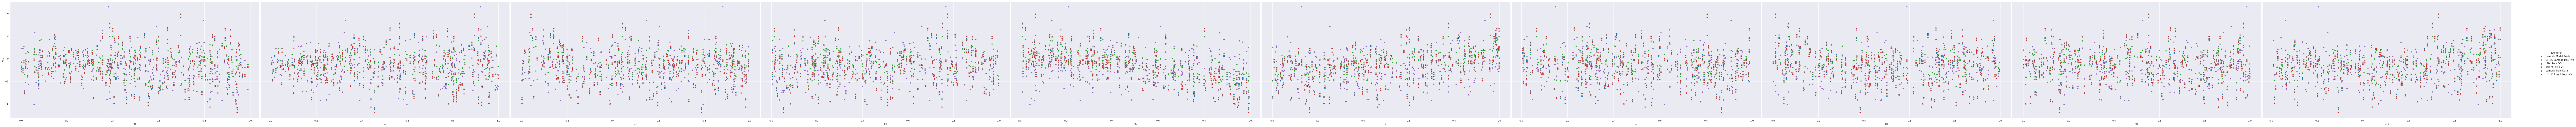

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.09244743487842112 |  0.99180016014036  |   -    |           -0.1129*a**1.0*b**1.0*c**1.0 -           |
|            vs.            |                     |                    |        |           0.3375*a**1.0*b**1.0*d**1.0 -            |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |           0.6261*a**1.0*b**1.0*e**1.0 +            |
|                           |                     |                    |        |           0.1709*a**1.0*b**1.0*f**1.0 +            |
|                           |                     |    

In [78]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

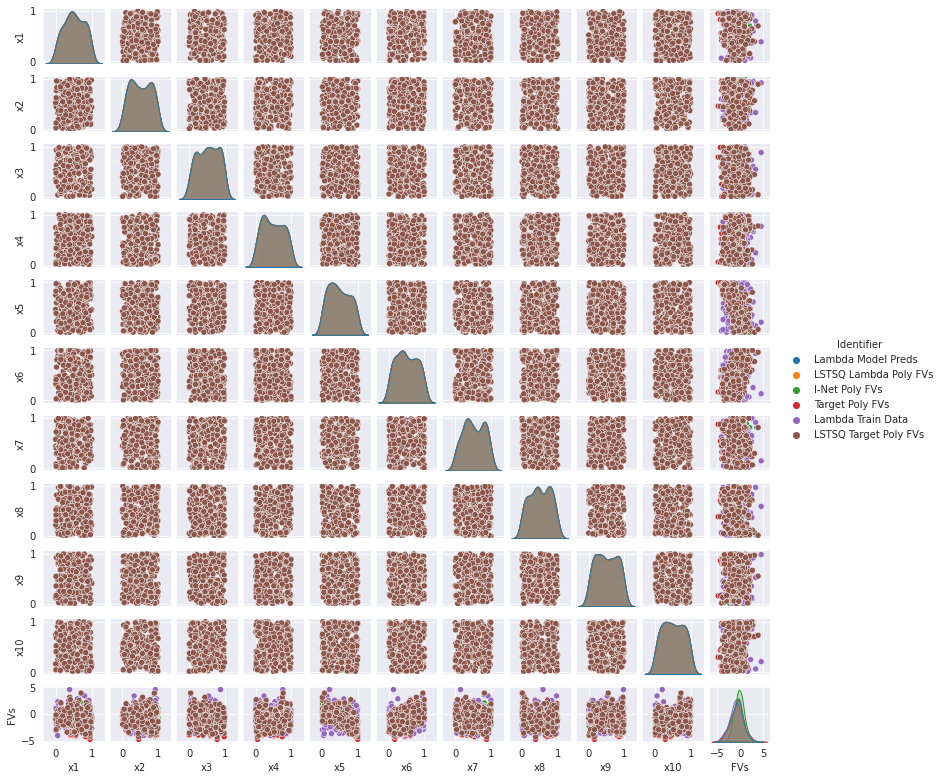

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.09244743487842112 |  0.99180016014036  |   -    |           -0.1129*a**1.0*b**1.0*c**1.0 -           |
|            vs.            |                     |                    |        |           0.3375*a**1.0*b**1.0*d**1.0 -            |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |           0.6261*a**1.0*b**1.0*e**1.0 +            |
|                           |                     |                    |        |           0.1709*a**1.0*b**1.0*f**1.0 +            |
|                           |                     |    

In [79]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

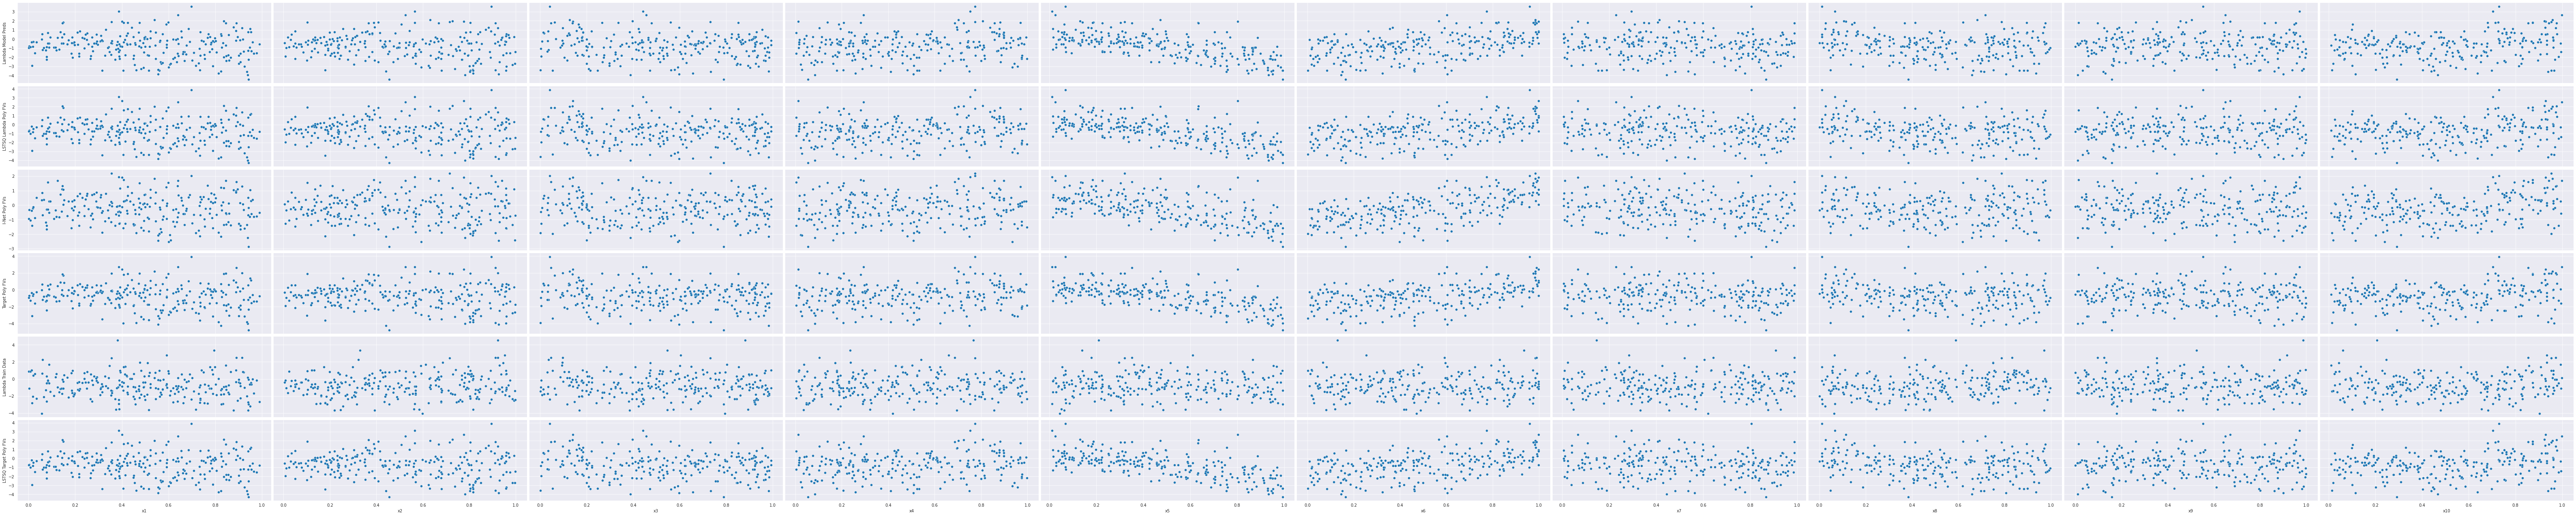

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.09244743487842112 |  0.99180016014036  |   -    |           -0.1129*a**1.0*b**1.0*c**1.0 -           |
|            vs.            |                     |                    |        |           0.3375*a**1.0*b**1.0*d**1.0 -            |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |           0.6261*a**1.0*b**1.0*e**1.0 +            |
|                           |                     |                    |        |           0.1709*a**1.0*b**1.0*f**1.0 +            |
|                           |                     |    

In [80]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [81]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [83]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()